### DESEQ2 analysis of Hydrogel dataset: Mammary glands vs 2D Soft vs 2D TCPS vs 3D Soft 

1 Factor design: 

* Sample :  100Pa3D, 2DSoft, 2DTCPS, Mamgland

* 52,977 idr peaks 
* 3 biological replicates per Sample (except 2 for Mamgland) 

In [105]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

## Load data and design

In [128]:
#load ATAC-seq raw read counts
data=read.table('mamgland.idr.atac.counts.txt',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$Chrom,data$Start,data$End,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL

#data=data[rowSums(data)>0,]


In [129]:
head(data)
print(nrow(data))

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2D_soft_Rep1,X2D_soft_Rep2,X2D_soft_Rep3,X2D_TCPS_Rep1,X2D_TCPS_Rep2,X2D_TCPS_Rep3,mamgland_Rep1,mamgland_Rep2
chr1_713708_714452,6,11,7,50,49,62,2,3,4,113,51
chr1_804992_805589,2,6,1,21,12,13,0,0,0,34,10
chr1_846336_846857,16,22,14,47,24,48,4,7,10,12,5
chr1_859087_859364,6,9,6,12,5,13,4,0,1,20,10
chr1_868304_868768,10,9,2,18,2,18,1,2,2,26,13
chr1_894444_894853,6,2,7,26,18,23,0,4,2,43,15


[1] 52976


In [130]:
#load the metadata
batches=read.table("batches_mamgland.txt",header=TRUE,sep='\t',row.names=1)
batches$Sample=factor(batches$Sample)


In [131]:
batches

,Sample
X100Pa_3D_Rep1,100Pa3D
X100Pa_3D_Rep2,100Pa3D
X100Pa_3D_Rep3,100Pa3D
X2D_soft_Rep1,2DSoft
X2D_soft_Rep2,2DSoft
X2D_soft_Rep3,2DSoft
X2D_TCPS_Rep1,2DTCPS
X2D_TCPS_Rep2,2DTCPS
X2D_TCPS_Rep3,2DTCPS
mamgland_Rep1,Mamgland


## PCA

In [132]:
#PCA on shifted log of normalized counts
normcounts=data
normcounts[normcounts<0]=0
lognc=log2(normcounts+1)
data.pca=prcomp(t(lognc))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)
print(var_explained_df)
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)



   seq.1..length.var_explained.. var_explained
1                              1         72.19
2                              2         12.88
3                              3          4.53
4                              4          2.37
5                              5          2.25
6                              6          1.43
7                              7          1.32
8                              8          1.15
9                              9          1.14
10                            10          0.74
11                            11          0.00


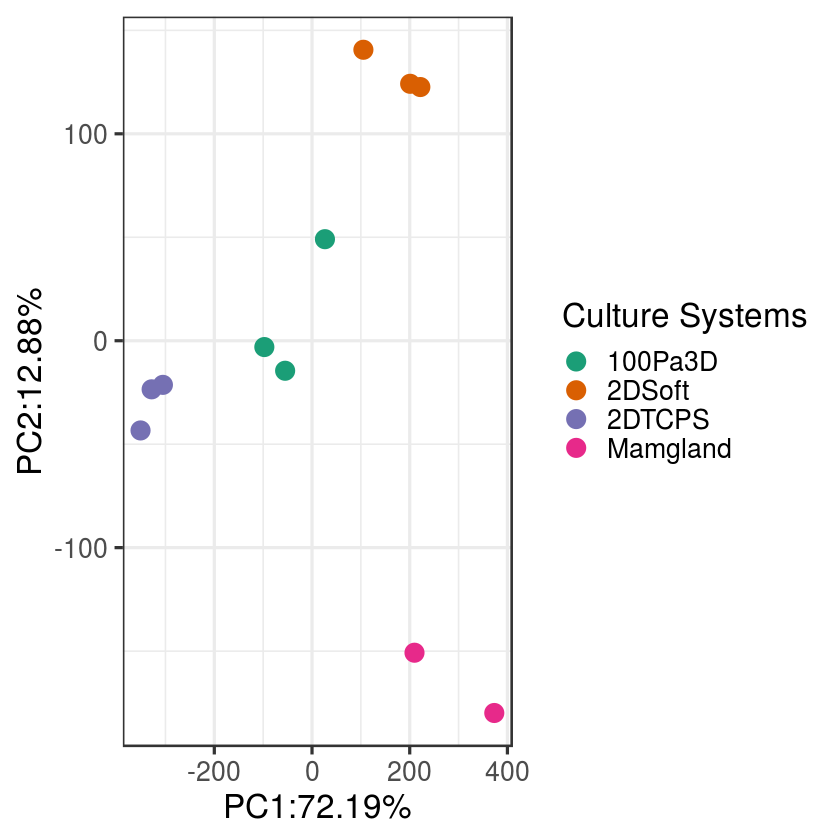

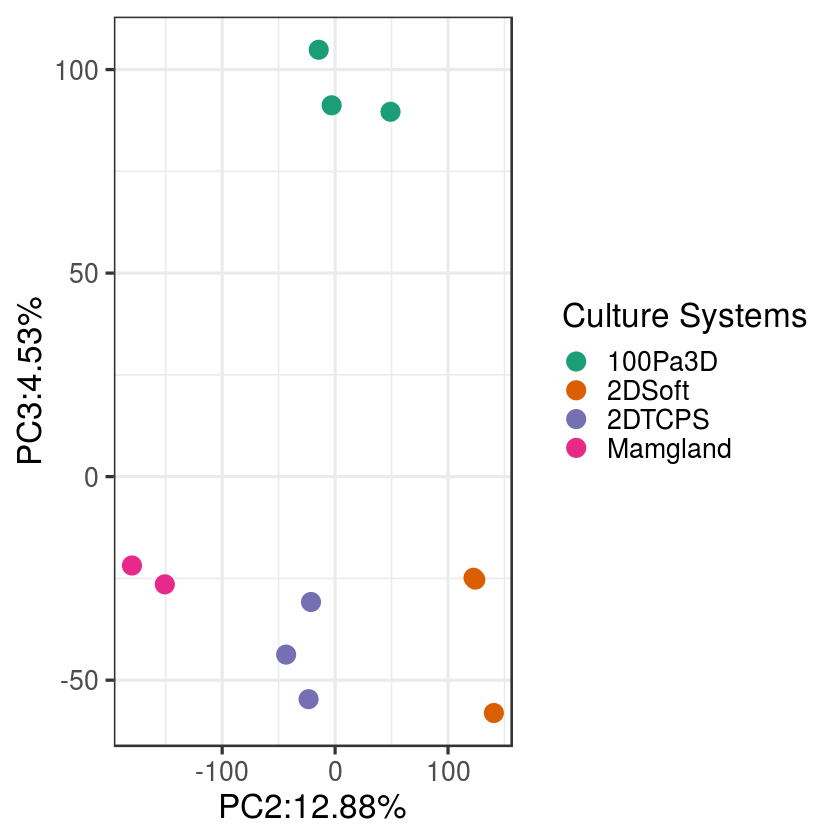

In [133]:

p1=ggplot(data=pca_df,
         aes(x=pca_df$PC1,
            y=pca_df$PC2,
            label=rownames(pca_df),
            color=pca_df$Sample))+
    geom_point(size=5)+
    xlab("PC1:72.19%")+
    ylab("PC2:12.88%")+
    scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'),name="Culture Systems")+
    theme_bw(20)
p1

p2=ggplot(data=pca_df,
         aes(x=pca_df$PC2,
            y=pca_df$PC3,
            label=rownames(pca_df),
            color=pca_df$Sample))+
    geom_point(size=5)+
    scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'),name="Culture Systems")+
    xlab("PC2:12.88%")+
    ylab("PC3:4.53%")+
    theme_bw(20)
p2

In [112]:
#Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = data,
                              colData = batches,
                              design = ~0+Sample)


## Differential Accessibility Operation

In [113]:
#Run the differential analysis
dds <- DESeq(dds,parallel = TRUE)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 20 workers


## Extract and store normalized counts for further analysis 

In [114]:
normcounts=counts(dds,normalized=TRUE)
write.table(normcounts,"normcounts_from_deseq.txt",quote=FALSE,sep='\t',col.names=TRUE,row.names=TRUE)


In [115]:
vsd=assay(vst(dds,blind=FALSE))
rld=assay(rlog(dds,blind=FALSE))
ntd <- assay(normTransform(dds))

In [116]:
head(normcounts)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2D_soft_Rep1,X2D_soft_Rep2,X2D_soft_Rep3,X2D_TCPS_Rep1,X2D_TCPS_Rep2,X2D_TCPS_Rep3,mamgland_Rep1,mamgland_Rep2
chr1_713708_714452,7.027506,9.442860,9.304143,23.162947,29.167785,26.844086,5.299569,7.468537,11.782823,35.881793,27.846977
chr1_804992_805589,2.342502,5.150651,1.329163,9.728438,7.143131,5.628599,0.000000,0.000000,0.000000,10.796292,5.460192
chr1_846336_846857,18.740017,18.885720,18.608286,21.773170,14.286262,20.782518,10.599138,17.426586,29.457057,3.810456,2.730096
chr1_859087_859364,7.027506,7.725976,7.974980,5.559107,2.976305,5.628599,10.599138,0.000000,2.945706,6.350760,5.460192
chr1_868304_868768,11.712511,7.725976,2.658327,8.338661,1.190522,7.793444,2.649785,4.979025,5.891411,8.255988,7.098249
chr1_894444_894853,7.027506,1.716884,9.304143,12.044732,10.714697,9.958290,0.000000,9.958049,5.891411,13.654133,8.190287


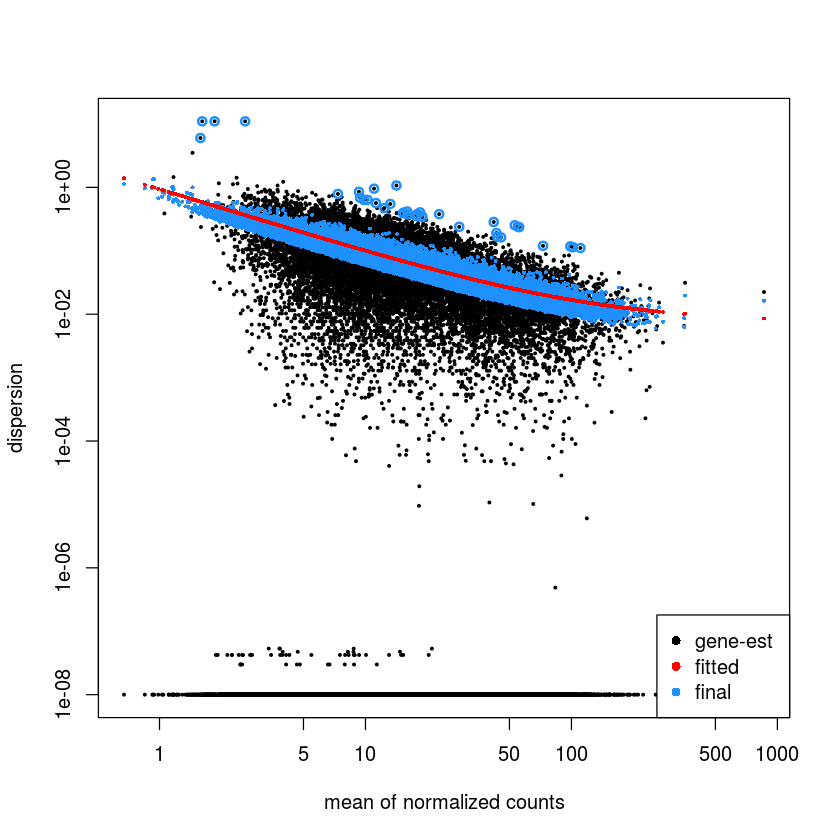

In [117]:
plotDispEsts(dds)

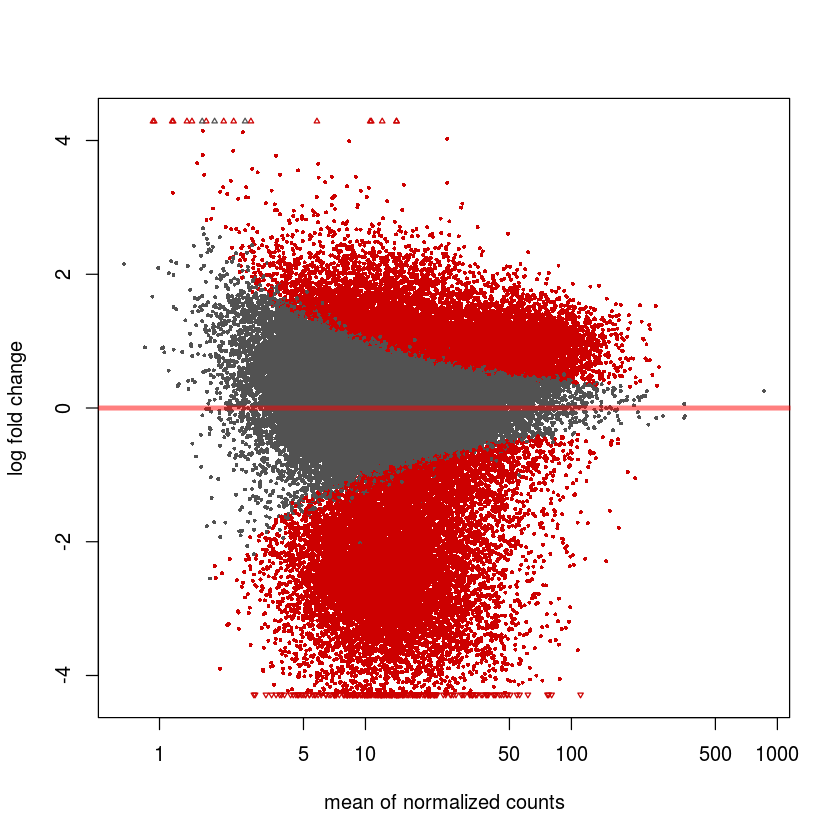

In [118]:
DESeq2::plotMA(dds)

## Standard BH Correction (no optimal thresholding) 

In [119]:
colors=colorRampPalette(c('#fff7f3','#fde0dd','#fcc5c0','#fa9fb5','#f768a1','#dd3497','#ae017e','#7a0177','#49006a'))(100)

[1] 10076


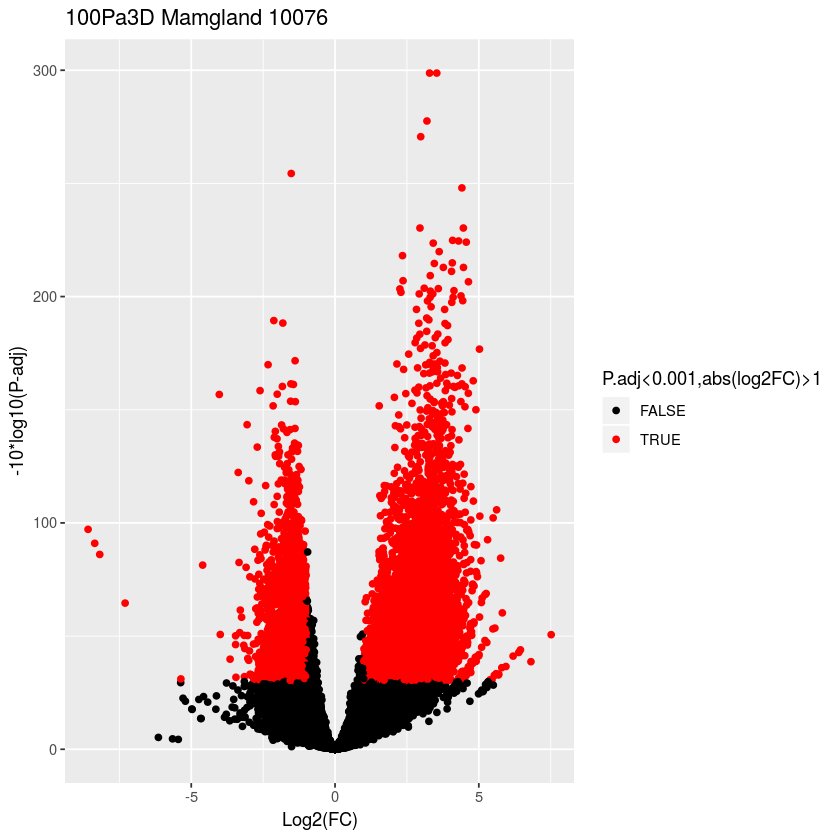

[1] 9895


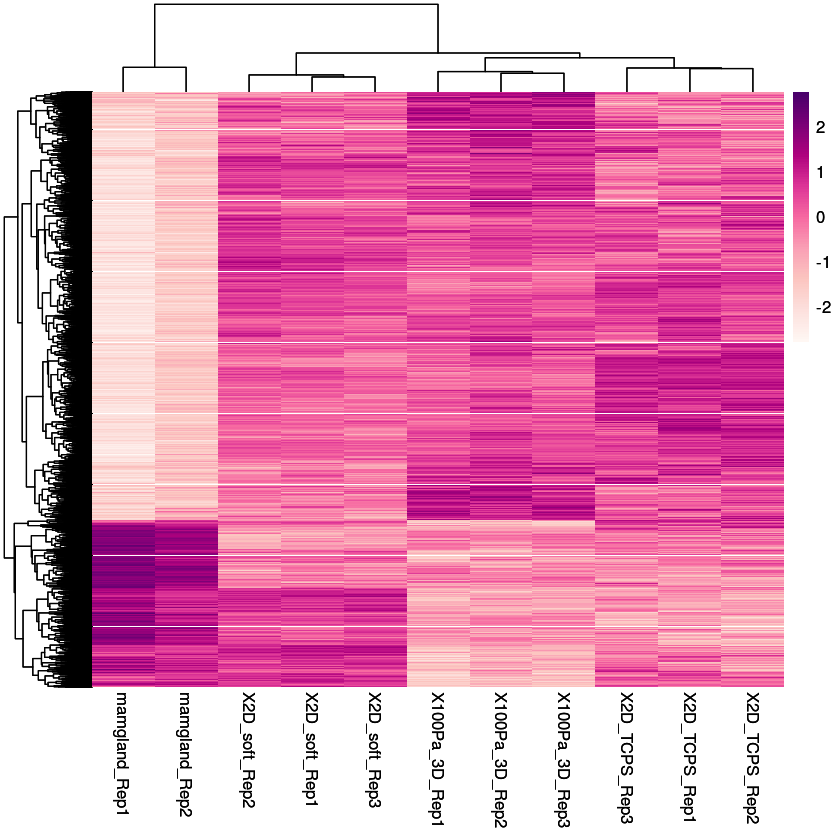

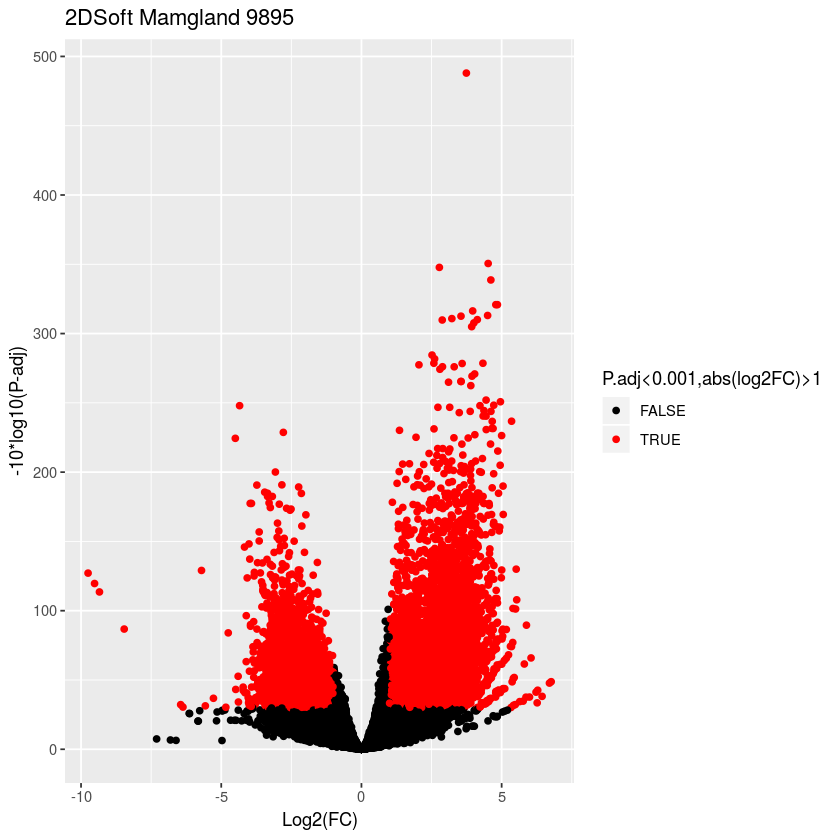

[1] 8381


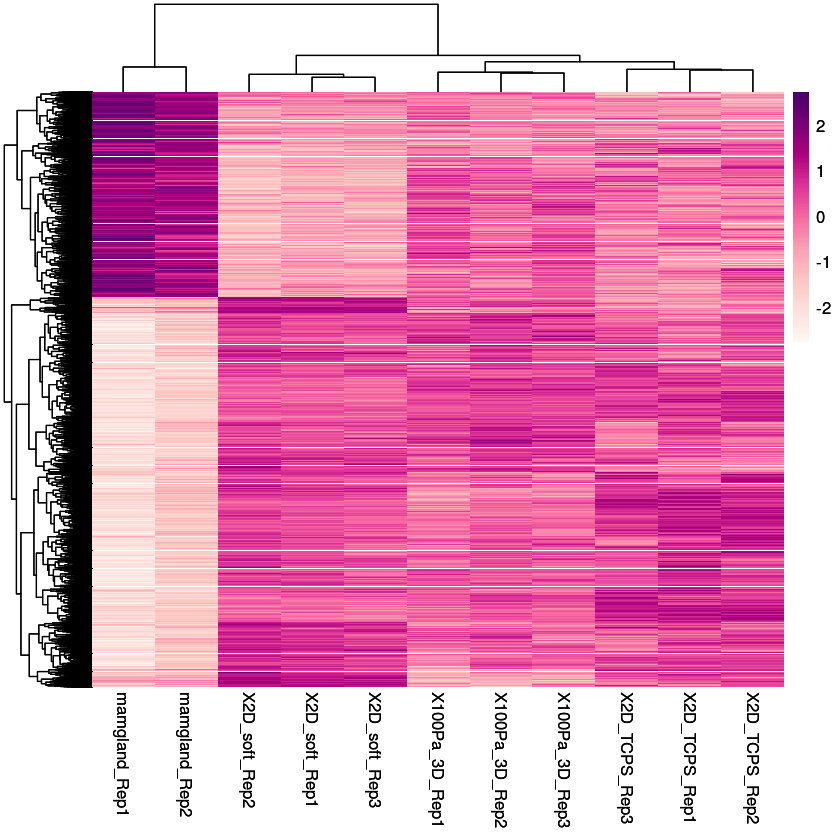

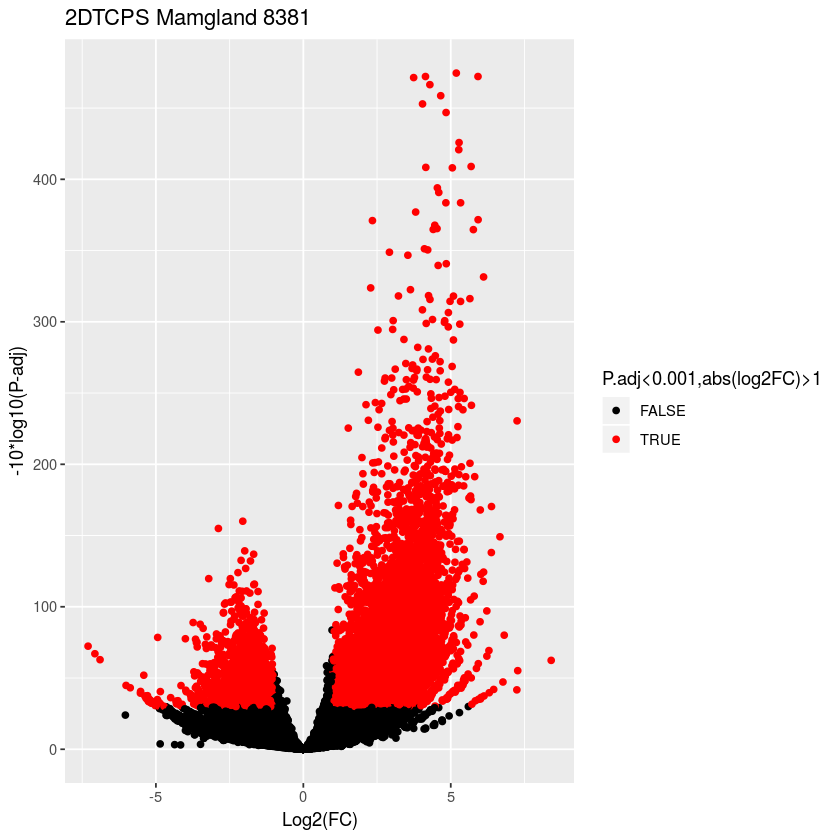

[1] 1231


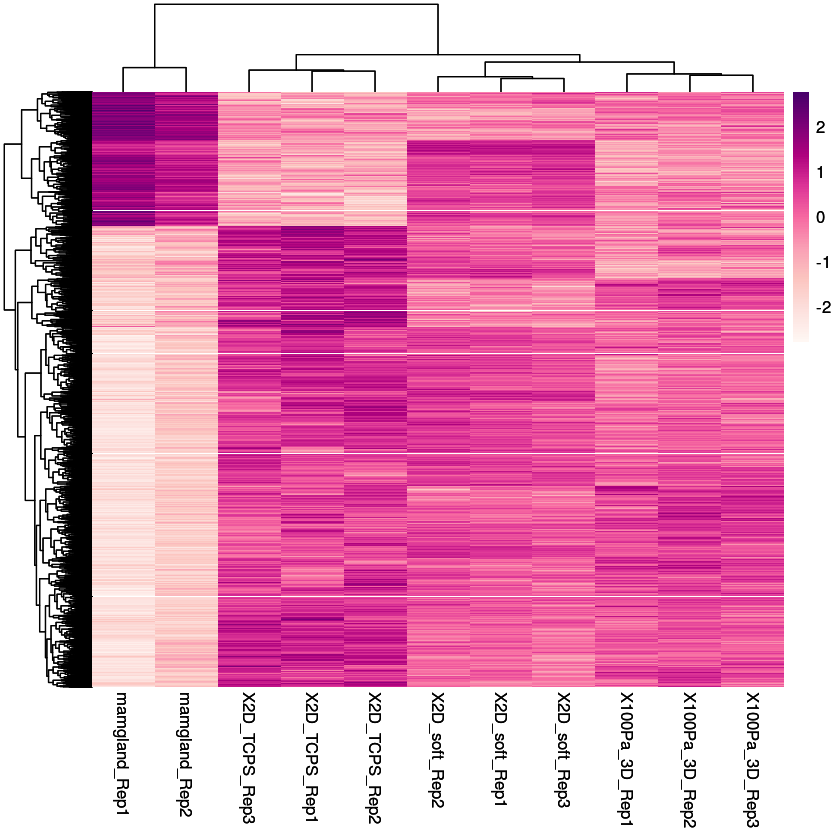

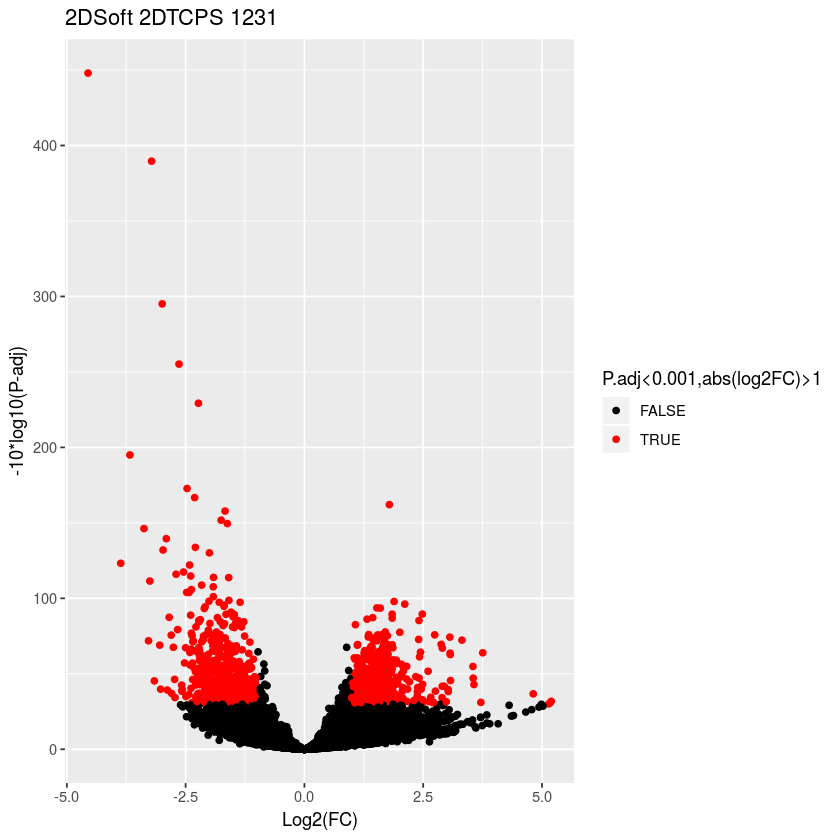

[1] 2477


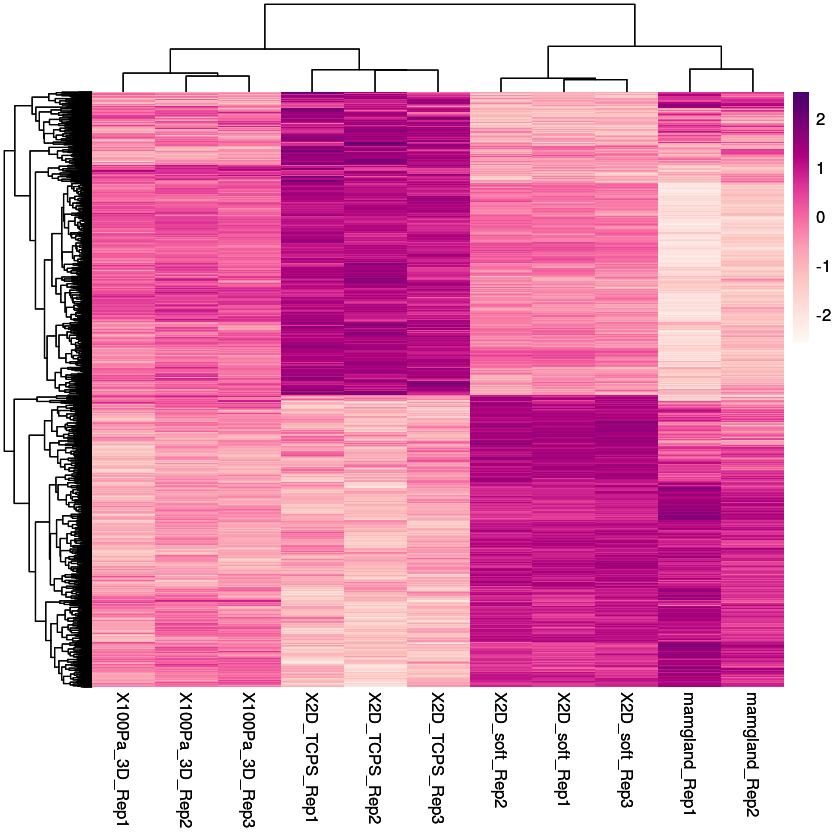

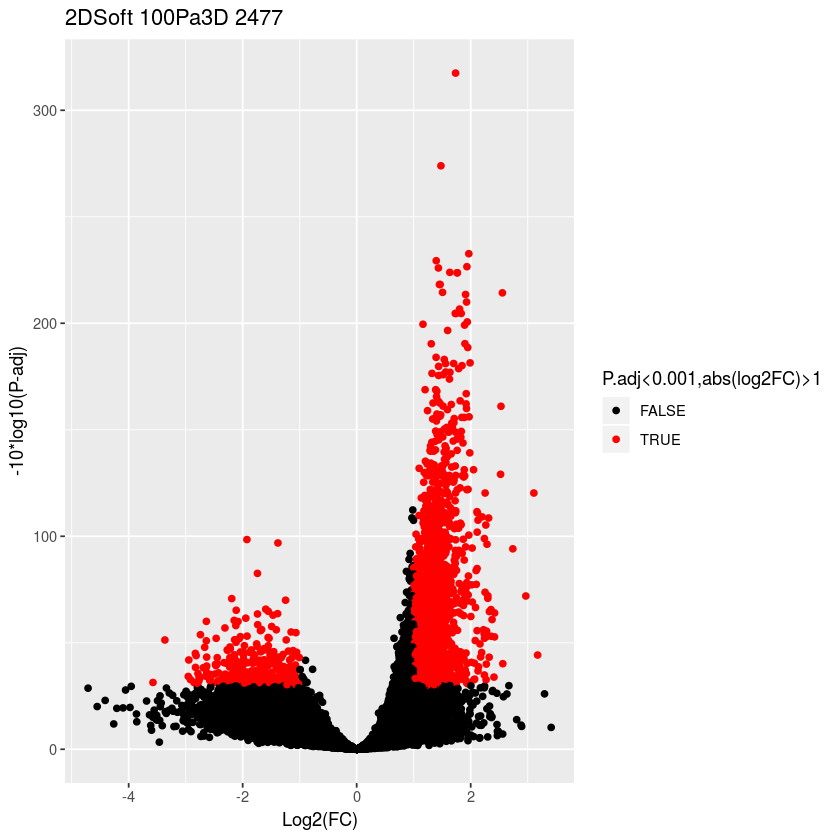

[1] 1063


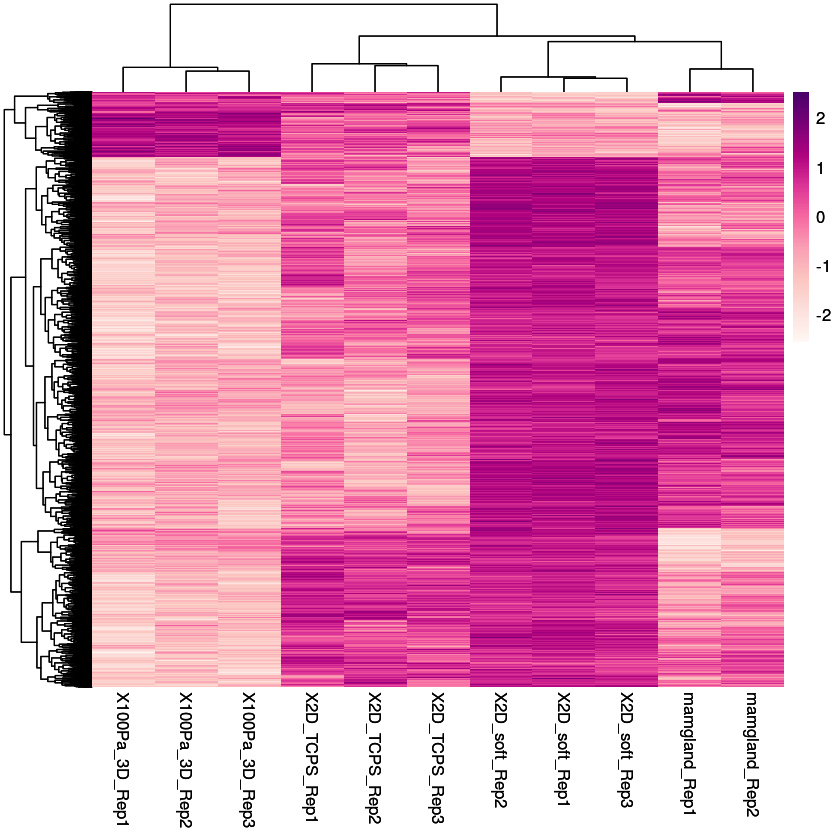

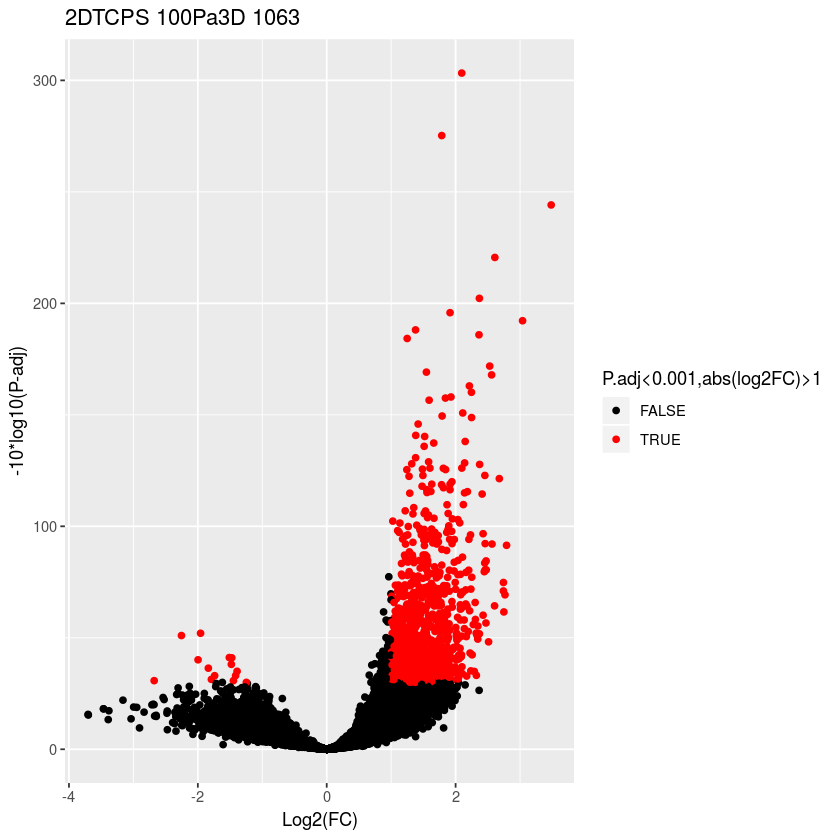

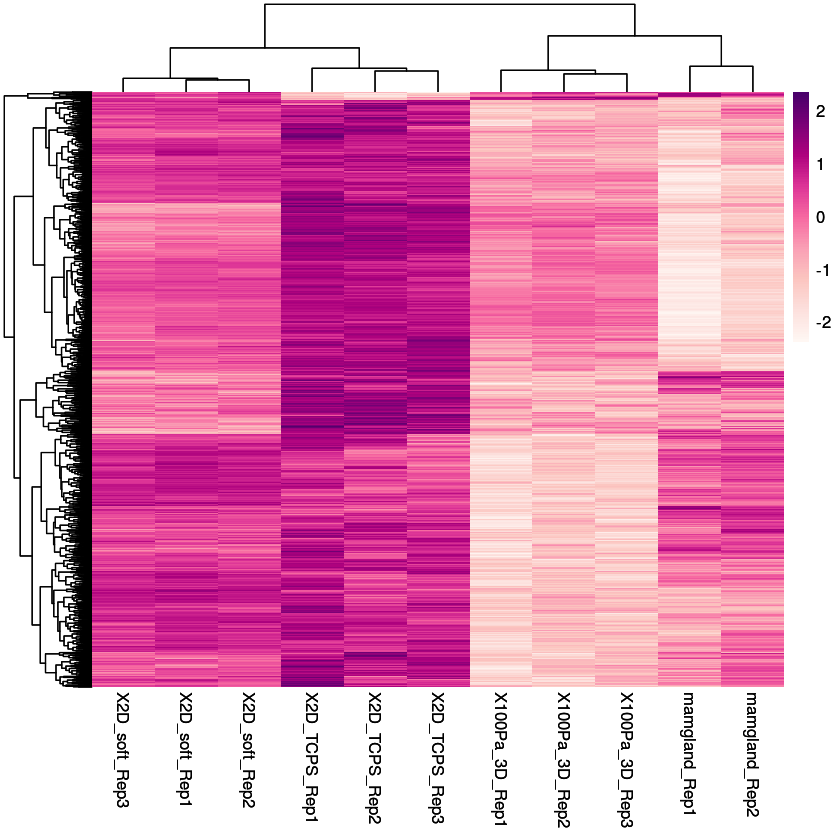

In [120]:
var=c("Sample","Sample","Sample","Sample","Sample","Sample")
s1=c("100Pa3D","2DSoft","2DTCPS","2DSoft","2DSoft","2DTCPS")
s2=c("Mamgland","Mamgland","Mamgland","2DTCPS","100Pa3D","100Pa3D")
numcomparisons=length(var)
for(i in seq(1,numcomparisons))
{
 contrast_inputs=c(var[i],s1[i],s2[i])
 res=results(dds,contrast=contrast_inputs,parallel=TRUE) 
 res$logPadj=-10*log10(res$padj)
 res=as.data.frame(res)
 res=na.omit(res)
 sigsubset=res[res$padj<=0.001,]
 sigsubset=sigsubset[abs(sigsubset$log2FoldChange)>1,]
 numsig=nrow(sigsubset)
 print(numsig)
 label=paste(s1[i],s2[i],numsig,sep=' ')

 #generate a volcano plot of the differential analysis for the contrast 
 res$color=(res$padj<=0.001 & abs(res$log2FoldChange)>1)
 print(ggplot(data=res,
 aes(x=res$log2FoldChange,
     y=res$logPadj,
     color=res$color))+
     geom_point()+
xlab("Log2(FC)")+
ylab("-10*log10(P-adj)")+
ggtitle(label)+
scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.001,abs(log2FC)>1"))
    
 #create a heatmap for the 
    ## Heatmap on Transformed Data 
forheatmap=rld[rownames(sigsubset),]

df <- as.data.frame(colData(dds)[,c("Sample")])
ph1=pheatmap(forheatmap,
         color=colors,
         cluster_rows=TRUE, 
         show_rownames=FALSE,
         scale='row',
         clustering_distance_rows='euclidean',
         clustering_distance_columns='euclidean',
         clustering_method_rows='ward.D',
         clustering_method_columns='ward.D',
         cluster_cols=TRUE)
print(ph1)
}


## PCA on normalized counts 

### ntd

In [121]:
data.pca=prcomp(t(ntd))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)



In [122]:
var_explained_df

seq.1..length.var_explained..,var_explained
1,39.99
2,14.14
3,12.61
4,11.11
5,9.58
6,3.43
7,2.91
8,2.66
9,2.12
10,1.44


In [123]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)


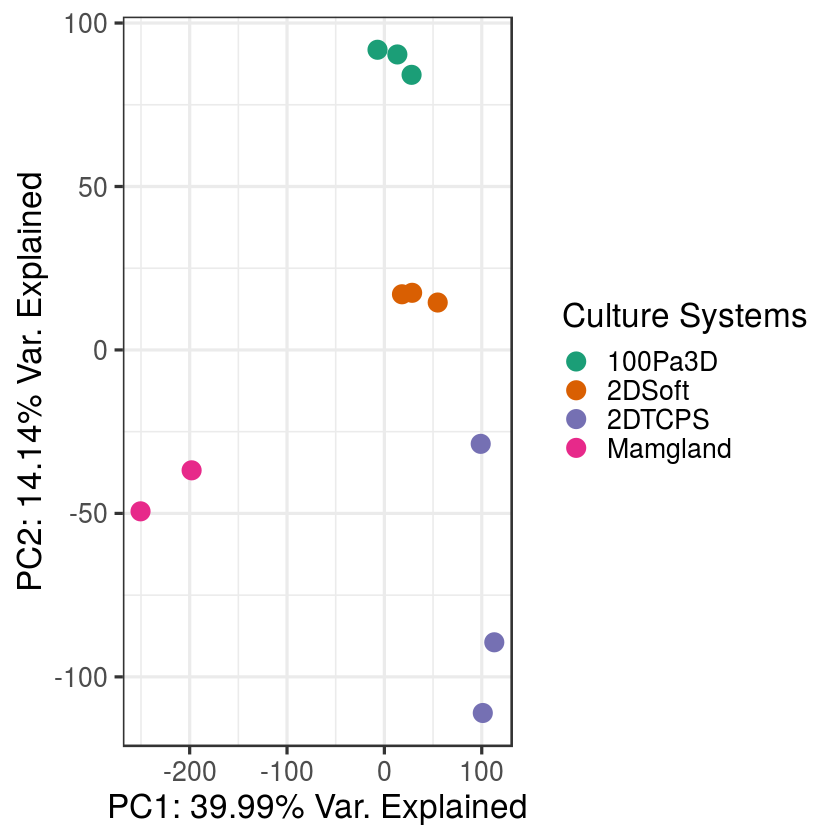

In [124]:
p1=ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Sample))+
  geom_point(size=5) +
  xlab("PC1: 39.99% Var. Explained")+
  ylab("PC2: 14.14% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'),name="Culture Systems")
p1
#svg("pca.svg",width = 8, height = 4, pointsize = 12)
#print(p1)
#dev.off()

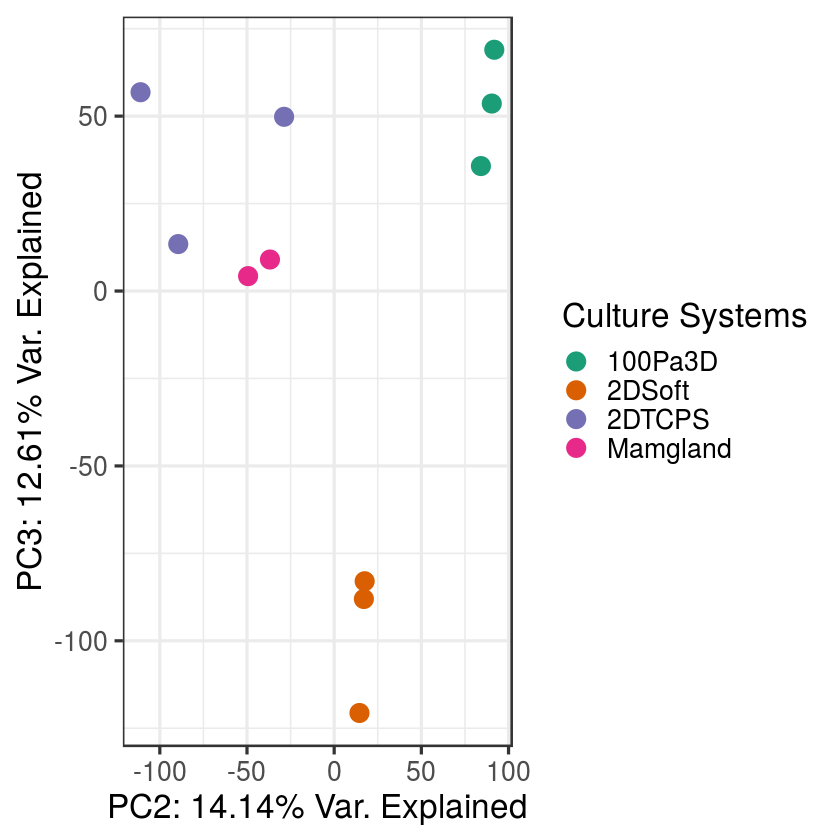

In [125]:
p2=ggplot(data=pca_df,aes(x=pca_df$PC2,y=pca_df$PC3,color=pca_df$Sample))+
  geom_point(size=5) +
  xlab("PC2: 14.14% Var. Explained")+
  ylab("PC3: 12.61% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'),name="Culture Systems")
p2

### VST

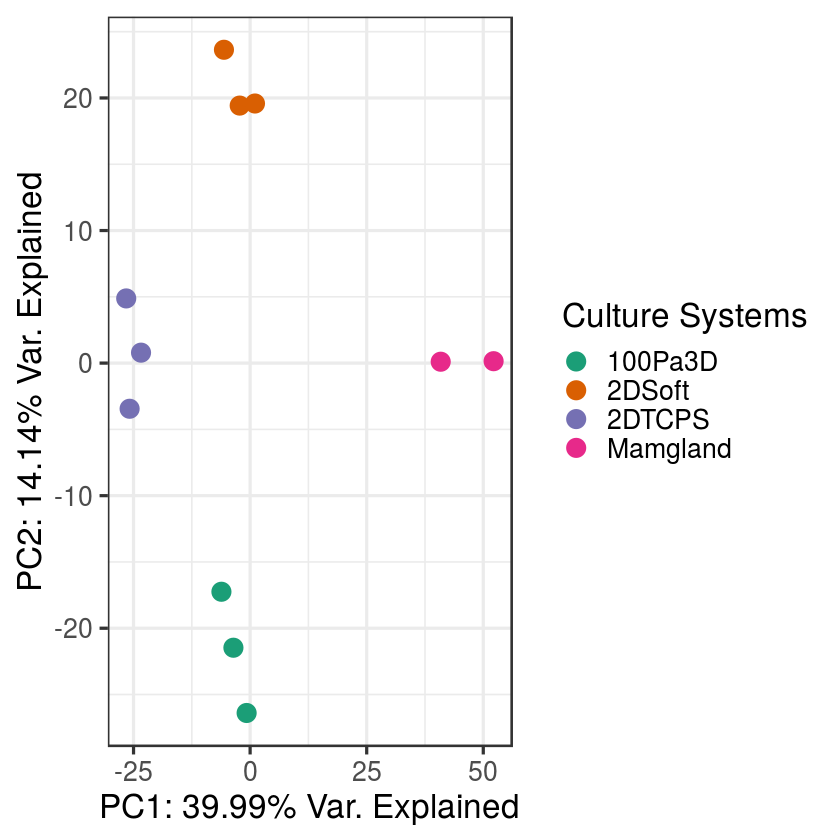

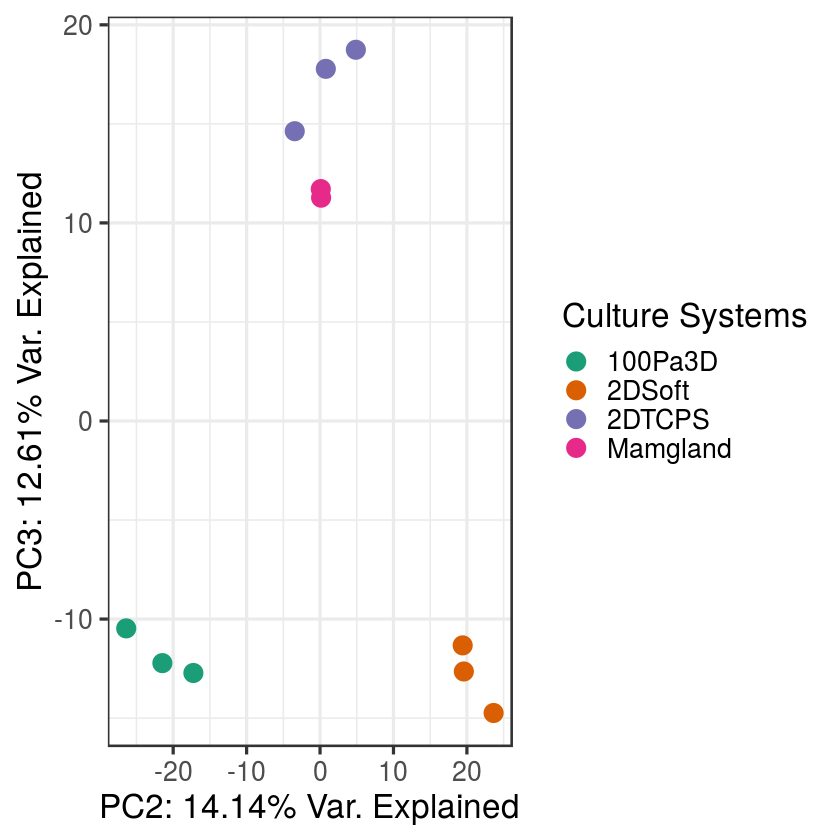

In [126]:
data.pca=prcomp(t(vsd))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)
p1=ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Sample))+
  geom_point(size=5) +
  xlab("PC1: 39.99% Var. Explained")+
  ylab("PC2: 14.14% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'),name="Culture Systems")
print(p1)
p2=ggplot(data=pca_df,aes(x=pca_df$PC2,y=pca_df$PC3,color=pca_df$Sample))+
  geom_point(size=5) +
  xlab("PC2: 14.14% Var. Explained")+
  ylab("PC3: 12.61% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'),name="Culture Systems")
print(p2)

### RLD

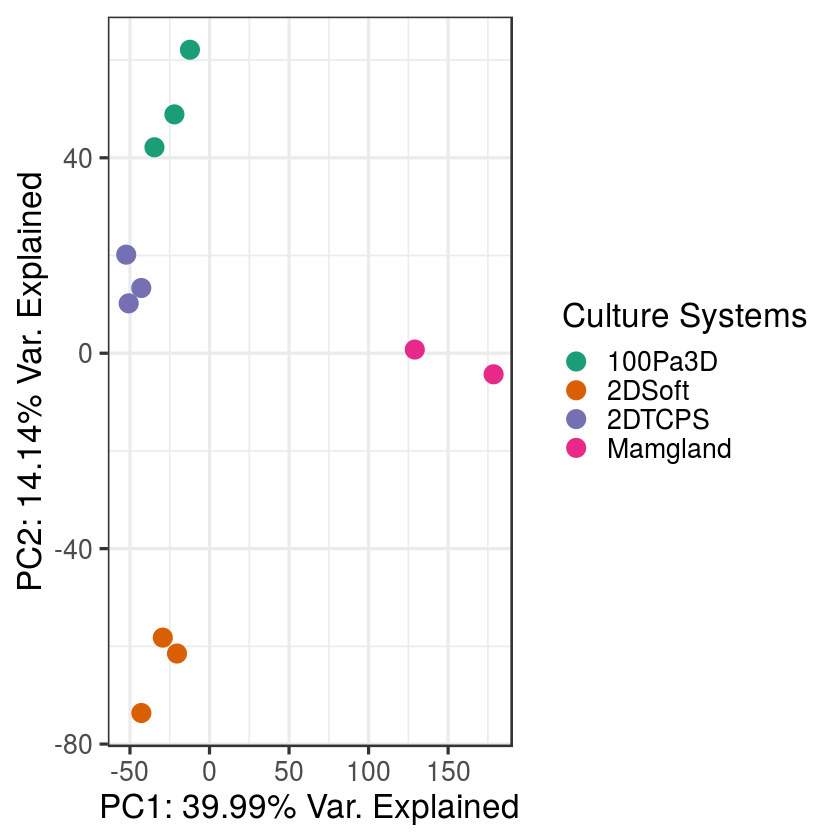

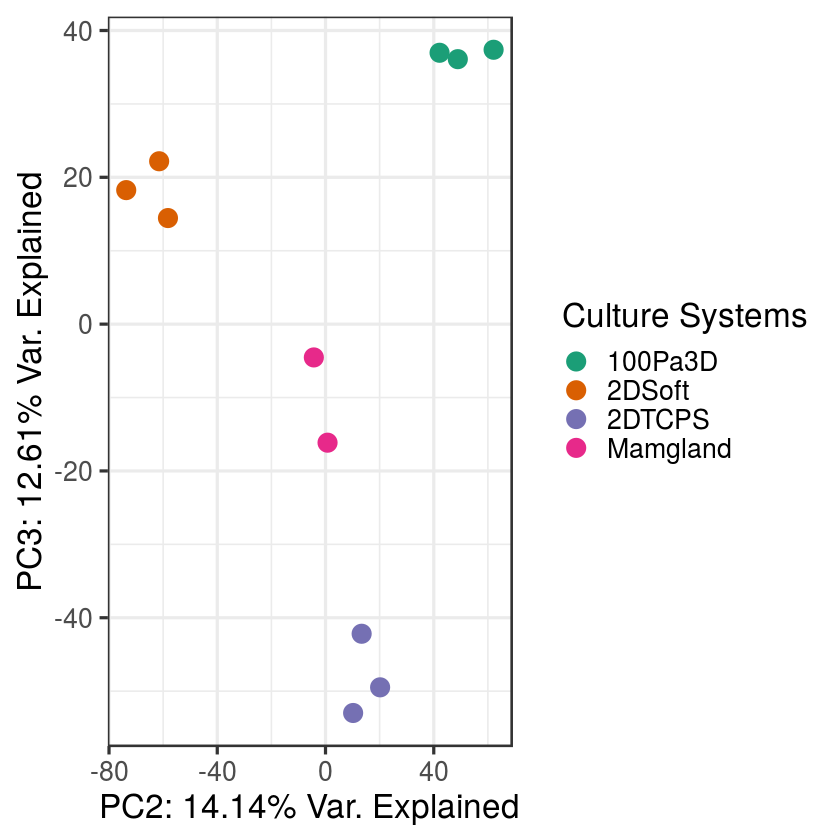

In [127]:
data.pca=prcomp(t(rld))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,batches)
p1=ggplot(data=pca_df,aes(x=pca_df$PC1,y=pca_df$PC2,color=pca_df$Sample))+
  geom_point(size=5) +
  xlab("PC1: 39.99% Var. Explained")+
  ylab("PC2: 14.14% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'),name="Culture Systems")
print(p1)
p2=ggplot(data=pca_df,aes(x=pca_df$PC2,y=pca_df$PC3,color=pca_df$Sample))+
  geom_point(size=5) +
  xlab("PC2: 14.14% Var. Explained")+
  ylab("PC3: 12.61% Var. Explained")+
  theme_bw(20)+
  scale_color_manual(values=c('#1b9e77','#d95f02','#7570b3','#e7298a'),name="Culture Systems")
print(p2)